In [1]:
import scipy.io as sio
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/BanglaHandwrittenDigit/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
import cv2
from tqdm import tqdm
import random
import os
np.random.seed(10)

In [3]:
DATA_DIR = data_path
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
IMG_SIZE = 28
CATEGORIES = ['0','1','2','3','4','5','6','7','8','9']
   
print(CATEGORIES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
width, height, channel = 28, 28, 3

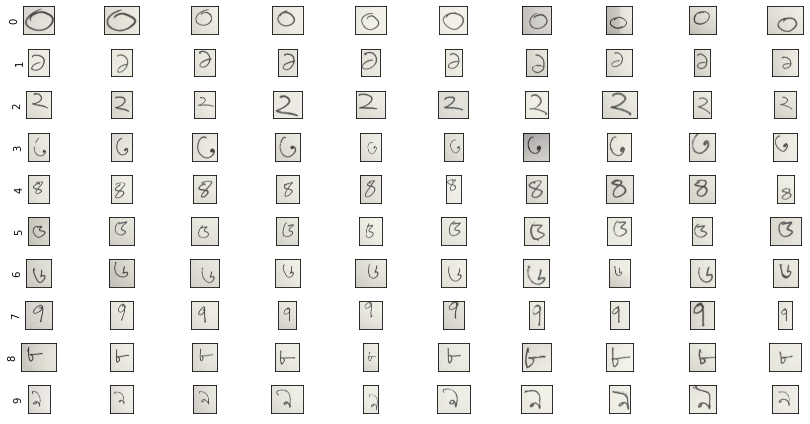

In [6]:
plt.figure(figsize=(12,6))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show()

In [7]:
X = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            X.append([img_resized, class_num]) 
        except WException as e:
            pass
        
print(len(X))

100%|██████████| 14/14 [00:00<00:00, 102.57it/s]

140


In [8]:
random.shuffle(X)

In [9]:
X_train = []
Y_train = []
# X_train.shape
for img, label in X:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (140, 28, 28, 3) Y_train= (140,)


In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [12]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Dense(2048, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), padding='same', activation = "tanh", kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [13]:
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              2099200   
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 2048)              0

In [24]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(28, 28, 3)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [25]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)              

In [26]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [27]:
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 3)         15126147  
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1029505   
                                                                 
Total params: 16,155,652
Trainable params: 15,107,331
Non-trainable params: 1,048,321
_________________________________________________________________


In [28]:
fixed_noise = np.random.normal(0, 1, size=(10, noise_dim))

In [29]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        cv2.resize(img, (28, 28)) 
        plt.imshow(img, cmap='gray')#.reshape((140,28,28,3)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [30]:
epochs = 1000
batch_size = 100
steps_per_epoch = len(X)//batch_size

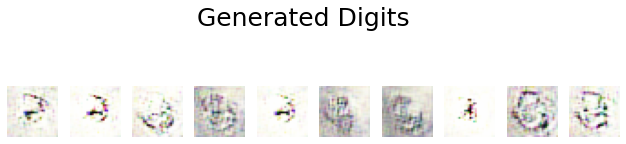

epoch:  546
discriminator loss:  0.5196939706802368
generator loss:  1.822460651397705
--------------------------------------------------------------------------------
epoch:  547
discriminator loss:  0.4656151831150055
generator loss:  0.8477391004562378
--------------------------------------------------------------------------------
epoch:  548
discriminator loss:  0.4608014225959778
generator loss:  1.5271577835083008
--------------------------------------------------------------------------------
epoch:  549
discriminator loss:  0.4465455710887909
generator loss:  1.1308655738830566
--------------------------------------------------------------------------------
epoch:  550
discriminator loss:  0.4269748628139496
generator loss:  1.2871520519256592
--------------------------------------------------------------------------------


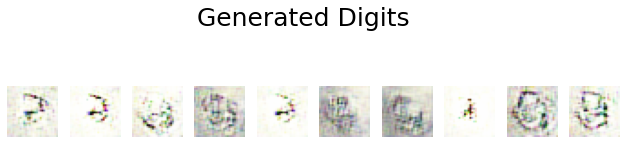

epoch:  551
discriminator loss:  0.43434303998947144
generator loss:  1.3632510900497437
--------------------------------------------------------------------------------
epoch:  552
discriminator loss:  0.43669554591178894
generator loss:  0.9766386151313782
--------------------------------------------------------------------------------
epoch:  553
discriminator loss:  0.4424213469028473
generator loss:  2.1520161628723145
--------------------------------------------------------------------------------
epoch:  554
discriminator loss:  0.6065486669540405
generator loss:  0.11289427429437637
--------------------------------------------------------------------------------
epoch:  555
discriminator loss:  1.1401782035827637
generator loss:  0.24561505019664764
--------------------------------------------------------------------------------


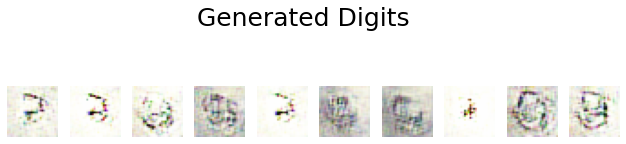

epoch:  556
discriminator loss:  0.8597555756568909
generator loss:  1.563347578048706
--------------------------------------------------------------------------------
epoch:  557
discriminator loss:  0.5446844100952148
generator loss:  1.4447437524795532
--------------------------------------------------------------------------------
epoch:  558
discriminator loss:  0.5544764995574951
generator loss:  0.7371109127998352
--------------------------------------------------------------------------------
epoch:  559
discriminator loss:  0.5454334616661072
generator loss:  0.8407177925109863
--------------------------------------------------------------------------------
epoch:  560
discriminator loss:  0.5214675068855286
generator loss:  1.2426172494888306
--------------------------------------------------------------------------------


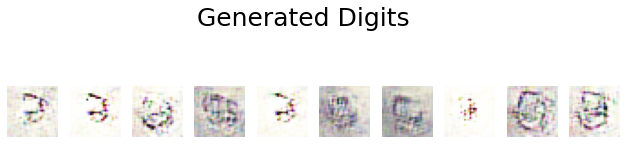

epoch:  561
discriminator loss:  0.5066583752632141
generator loss:  1.1558165550231934
--------------------------------------------------------------------------------
epoch:  562
discriminator loss:  0.4795503616333008
generator loss:  0.9745347499847412
--------------------------------------------------------------------------------
epoch:  563
discriminator loss:  0.47344204783439636
generator loss:  1.1218794584274292
--------------------------------------------------------------------------------
epoch:  564
discriminator loss:  0.4677123725414276
generator loss:  1.1610912084579468
--------------------------------------------------------------------------------
epoch:  565
discriminator loss:  0.4626227617263794
generator loss:  1.0310170650482178
--------------------------------------------------------------------------------


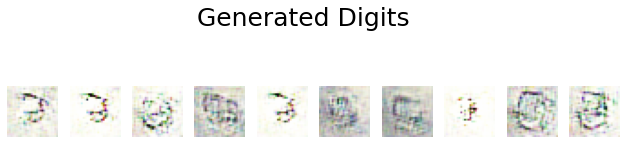

epoch:  566
discriminator loss:  0.4508247375488281
generator loss:  1.358917236328125
--------------------------------------------------------------------------------
epoch:  567
discriminator loss:  0.46894654631614685
generator loss:  0.8016130328178406
--------------------------------------------------------------------------------
epoch:  568
discriminator loss:  0.4855768084526062
generator loss:  1.3991332054138184
--------------------------------------------------------------------------------
epoch:  569
discriminator loss:  0.4648471772670746
generator loss:  0.9569854736328125
--------------------------------------------------------------------------------
epoch:  570
discriminator loss:  0.46344542503356934
generator loss:  1.403175711631775
--------------------------------------------------------------------------------


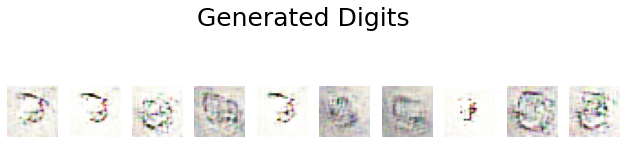

epoch:  571
discriminator loss:  0.45973071455955505
generator loss:  0.9079126119613647
--------------------------------------------------------------------------------
epoch:  572
discriminator loss:  0.4663260579109192
generator loss:  1.7995514869689941
--------------------------------------------------------------------------------
epoch:  573
discriminator loss:  0.5001246333122253
generator loss:  0.3784985840320587
--------------------------------------------------------------------------------
epoch:  574
discriminator loss:  0.6961202025413513
generator loss:  1.4124209880828857
--------------------------------------------------------------------------------
epoch:  575
discriminator loss:  0.449422687292099
generator loss:  1.8603050708770752
--------------------------------------------------------------------------------


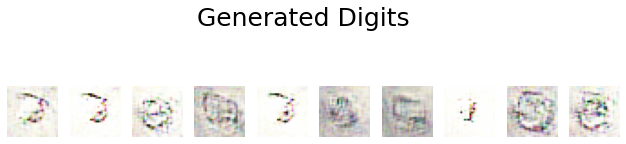

epoch:  576
discriminator loss:  0.5275692939758301
generator loss:  0.5333390831947327
--------------------------------------------------------------------------------
epoch:  577
discriminator loss:  0.6091558933258057
generator loss:  1.1940665245056152
--------------------------------------------------------------------------------
epoch:  578
discriminator loss:  0.4379790425300598
generator loss:  1.9833364486694336
--------------------------------------------------------------------------------
epoch:  579
discriminator loss:  0.5321187973022461
generator loss:  0.552655041217804
--------------------------------------------------------------------------------
epoch:  580
discriminator loss:  0.6016508340835571
generator loss:  1.1099960803985596
--------------------------------------------------------------------------------


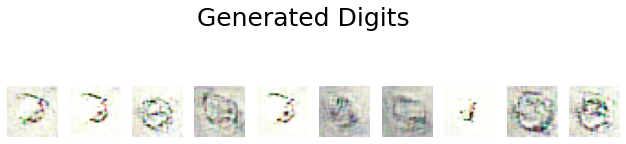

epoch:  581
discriminator loss:  0.455725759267807
generator loss:  2.0309879779815674
--------------------------------------------------------------------------------
epoch:  582
discriminator loss:  0.5564897060394287
generator loss:  0.6272150278091431
--------------------------------------------------------------------------------
epoch:  583
discriminator loss:  0.5471459627151489
generator loss:  1.0181527137756348
--------------------------------------------------------------------------------
epoch:  584
discriminator loss:  0.4634673595428467
generator loss:  1.722112774848938
--------------------------------------------------------------------------------
epoch:  585
discriminator loss:  0.48356011509895325
generator loss:  1.000807523727417
--------------------------------------------------------------------------------


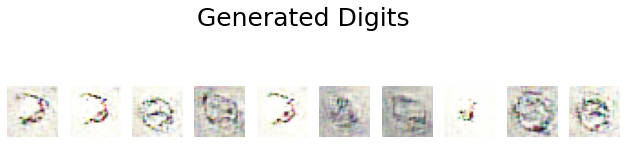

epoch:  586
discriminator loss:  0.4649369418621063
generator loss:  1.1598906517028809
--------------------------------------------------------------------------------
epoch:  587
discriminator loss:  0.45155826210975647
generator loss:  1.4971210956573486
--------------------------------------------------------------------------------
epoch:  588
discriminator loss:  0.4530443847179413
generator loss:  1.105905532836914
--------------------------------------------------------------------------------
epoch:  589
discriminator loss:  0.46130621433258057
generator loss:  1.2874786853790283
--------------------------------------------------------------------------------
epoch:  590
discriminator loss:  0.43872249126434326
generator loss:  1.2089531421661377
--------------------------------------------------------------------------------


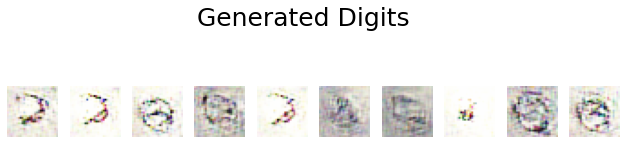

epoch:  591
discriminator loss:  0.43474167585372925
generator loss:  1.4031152725219727
--------------------------------------------------------------------------------
epoch:  592
discriminator loss:  0.45010849833488464
generator loss:  0.8750887513160706
--------------------------------------------------------------------------------
epoch:  593
discriminator loss:  0.450430303812027
generator loss:  1.7827459573745728
--------------------------------------------------------------------------------
epoch:  594
discriminator loss:  0.4736015796661377
generator loss:  0.547569990158081
--------------------------------------------------------------------------------
epoch:  595
discriminator loss:  0.5911363959312439
generator loss:  1.7755049467086792
--------------------------------------------------------------------------------


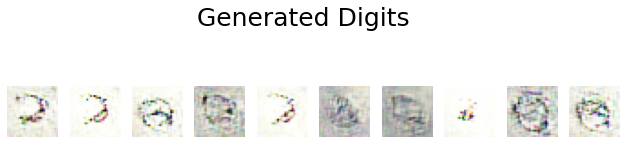

epoch:  596
discriminator loss:  0.48700082302093506
generator loss:  0.7588244676589966
--------------------------------------------------------------------------------
epoch:  597
discriminator loss:  0.4897019863128662
generator loss:  1.4563016891479492
--------------------------------------------------------------------------------
epoch:  598
discriminator loss:  0.43956485390663147
generator loss:  1.3015203475952148
--------------------------------------------------------------------------------
epoch:  599
discriminator loss:  0.43718892335891724
generator loss:  1.2078545093536377
--------------------------------------------------------------------------------
epoch:  600
discriminator loss:  0.43587788939476013
generator loss:  1.4845881462097168
--------------------------------------------------------------------------------


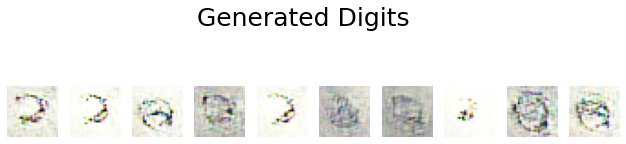

epoch:  601
discriminator loss:  0.4267975687980652
generator loss:  1.0976879596710205
--------------------------------------------------------------------------------
epoch:  602
discriminator loss:  0.4309276342391968
generator loss:  1.8446495532989502
--------------------------------------------------------------------------------
epoch:  603
discriminator loss:  0.4848199784755707
generator loss:  0.35757654905319214
--------------------------------------------------------------------------------
epoch:  604
discriminator loss:  0.6962174773216248
generator loss:  1.2645660638809204
--------------------------------------------------------------------------------
epoch:  605
discriminator loss:  0.43740466237068176
generator loss:  2.1133363246917725
--------------------------------------------------------------------------------


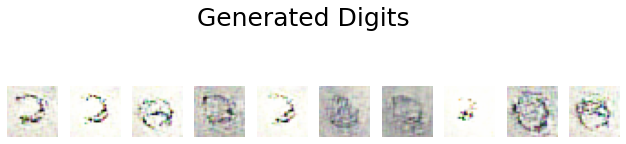

epoch:  606
discriminator loss:  0.5601215362548828
generator loss:  0.33753201365470886
--------------------------------------------------------------------------------
epoch:  607
discriminator loss:  0.7733431458473206
generator loss:  0.7919303774833679
--------------------------------------------------------------------------------
epoch:  608
discriminator loss:  0.496903657913208
generator loss:  2.370941162109375
--------------------------------------------------------------------------------
epoch:  609
discriminator loss:  0.7135134935379028
generator loss:  0.4800763726234436
--------------------------------------------------------------------------------
epoch:  610
discriminator loss:  0.6376417279243469
generator loss:  0.7322802543640137
--------------------------------------------------------------------------------


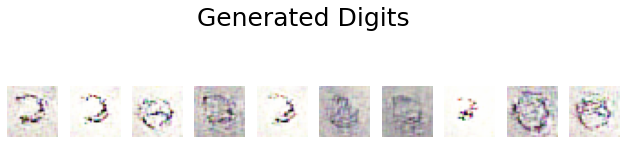

epoch:  611
discriminator loss:  0.5504140257835388
generator loss:  1.639678955078125
--------------------------------------------------------------------------------
epoch:  612
discriminator loss:  0.5084409117698669
generator loss:  1.2511829137802124
--------------------------------------------------------------------------------
epoch:  613
discriminator loss:  0.491140753030777
generator loss:  0.9264349937438965
--------------------------------------------------------------------------------
epoch:  614
discriminator loss:  0.4808032214641571
generator loss:  1.2571295499801636
--------------------------------------------------------------------------------
epoch:  615
discriminator loss:  0.4519999623298645
generator loss:  1.3595716953277588
--------------------------------------------------------------------------------


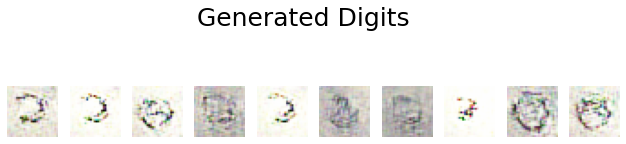

epoch:  616
discriminator loss:  0.45796990394592285
generator loss:  1.0595744848251343
--------------------------------------------------------------------------------
epoch:  617
discriminator loss:  0.44808799028396606
generator loss:  1.213709831237793
--------------------------------------------------------------------------------
epoch:  618
discriminator loss:  0.4376818537712097
generator loss:  1.3262488842010498
--------------------------------------------------------------------------------
epoch:  619
discriminator loss:  0.4583466649055481
generator loss:  1.0172315835952759
--------------------------------------------------------------------------------
epoch:  620
discriminator loss:  0.4422881007194519
generator loss:  1.3879846334457397
--------------------------------------------------------------------------------


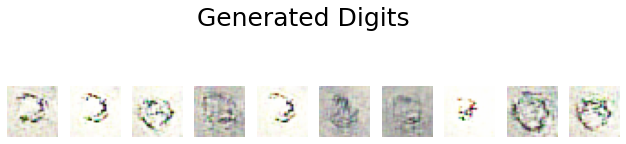

epoch:  621
discriminator loss:  0.4436243772506714
generator loss:  1.0925637483596802
--------------------------------------------------------------------------------
epoch:  622
discriminator loss:  0.45675554871559143
generator loss:  1.4411731958389282
--------------------------------------------------------------------------------
epoch:  623
discriminator loss:  0.44333651661872864
generator loss:  0.828275740146637
--------------------------------------------------------------------------------
epoch:  624
discriminator loss:  0.48848244547843933
generator loss:  1.7370027303695679
--------------------------------------------------------------------------------
epoch:  625
discriminator loss:  0.48692744970321655
generator loss:  0.6353577971458435
--------------------------------------------------------------------------------


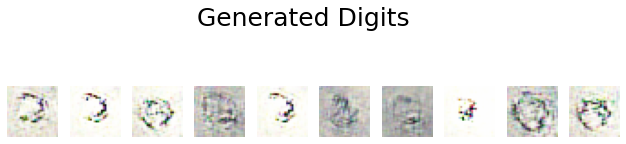

epoch:  626
discriminator loss:  0.5327918529510498
generator loss:  1.4665751457214355
--------------------------------------------------------------------------------
epoch:  627
discriminator loss:  0.4475751519203186
generator loss:  1.6153268814086914
--------------------------------------------------------------------------------
epoch:  628
discriminator loss:  0.46755391359329224
generator loss:  0.7341564297676086
--------------------------------------------------------------------------------
epoch:  629
discriminator loss:  0.5311160087585449
generator loss:  1.4705138206481934
--------------------------------------------------------------------------------
epoch:  630
discriminator loss:  0.45460784435272217
generator loss:  1.411454677581787
--------------------------------------------------------------------------------


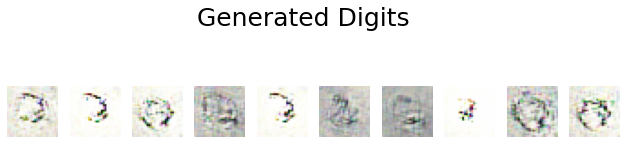

epoch:  631
discriminator loss:  0.44414791464805603
generator loss:  1.0201385021209717
--------------------------------------------------------------------------------
epoch:  632
discriminator loss:  0.4505821168422699
generator loss:  1.580385446548462
--------------------------------------------------------------------------------
epoch:  633
discriminator loss:  0.4578043222427368
generator loss:  0.9112268686294556
--------------------------------------------------------------------------------
epoch:  634
discriminator loss:  0.4752868711948395
generator loss:  2.0264878273010254
--------------------------------------------------------------------------------
epoch:  635
discriminator loss:  0.5095692276954651
generator loss:  0.3736095428466797
--------------------------------------------------------------------------------


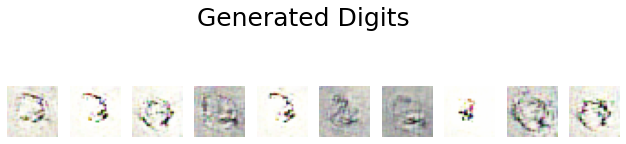

epoch:  636
discriminator loss:  0.7292140126228333
generator loss:  1.2344403266906738
--------------------------------------------------------------------------------
epoch:  637
discriminator loss:  0.45649367570877075
generator loss:  2.002882480621338
--------------------------------------------------------------------------------
epoch:  638
discriminator loss:  0.5248589515686035
generator loss:  0.6468040347099304
--------------------------------------------------------------------------------
epoch:  639
discriminator loss:  0.5546244978904724
generator loss:  1.1923942565917969
--------------------------------------------------------------------------------
epoch:  640
discriminator loss:  0.44527262449264526
generator loss:  1.7167539596557617
--------------------------------------------------------------------------------


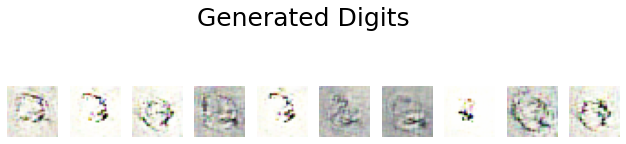

epoch:  641
discriminator loss:  0.4867205321788788
generator loss:  0.8568251729011536
--------------------------------------------------------------------------------
epoch:  642
discriminator loss:  0.5069981217384338
generator loss:  1.3588675260543823
--------------------------------------------------------------------------------
epoch:  643
discriminator loss:  0.44068992137908936
generator loss:  1.3348736763000488
--------------------------------------------------------------------------------
epoch:  644
discriminator loss:  0.427725613117218
generator loss:  1.1348289251327515
--------------------------------------------------------------------------------
epoch:  645
discriminator loss:  0.44631245732307434
generator loss:  1.5237541198730469
--------------------------------------------------------------------------------


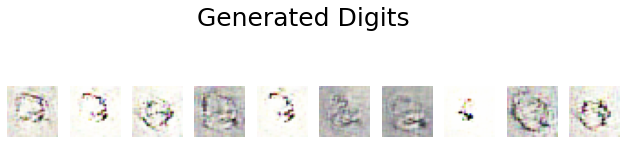

epoch:  646
discriminator loss:  0.43878233432769775
generator loss:  0.9233071208000183
--------------------------------------------------------------------------------
epoch:  647
discriminator loss:  0.4421693682670593
generator loss:  1.6655926704406738
--------------------------------------------------------------------------------
epoch:  648
discriminator loss:  0.4624555706977844
generator loss:  0.6907752752304077
--------------------------------------------------------------------------------
epoch:  649
discriminator loss:  0.5121489763259888
generator loss:  1.7074687480926514
--------------------------------------------------------------------------------
epoch:  650
discriminator loss:  0.4488769471645355
generator loss:  0.9353458881378174
--------------------------------------------------------------------------------


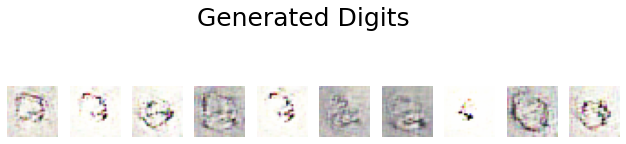

epoch:  651
discriminator loss:  0.45470139384269714
generator loss:  1.5979008674621582
--------------------------------------------------------------------------------
epoch:  652
discriminator loss:  0.45217981934547424
generator loss:  0.8653711676597595
--------------------------------------------------------------------------------
epoch:  653
discriminator loss:  0.4690757393836975
generator loss:  2.0269932746887207
--------------------------------------------------------------------------------
epoch:  654
discriminator loss:  0.5097988247871399
generator loss:  0.36256107687950134
--------------------------------------------------------------------------------
epoch:  655
discriminator loss:  0.6925719976425171
generator loss:  1.2513507604599
--------------------------------------------------------------------------------


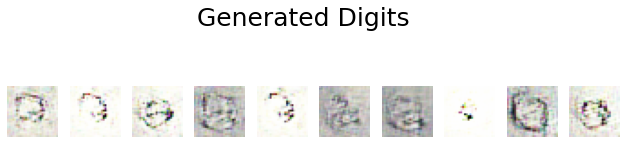

epoch:  656
discriminator loss:  0.43446338176727295
generator loss:  2.0982582569122314
--------------------------------------------------------------------------------
epoch:  657
discriminator loss:  0.58315509557724
generator loss:  0.35351166129112244
--------------------------------------------------------------------------------
epoch:  658
discriminator loss:  0.6972278356552124
generator loss:  0.8449721336364746
--------------------------------------------------------------------------------
epoch:  659
discriminator loss:  0.4783729612827301
generator loss:  2.3370914459228516
--------------------------------------------------------------------------------
epoch:  660
discriminator loss:  0.6453097462654114
generator loss:  0.4933926463127136
--------------------------------------------------------------------------------


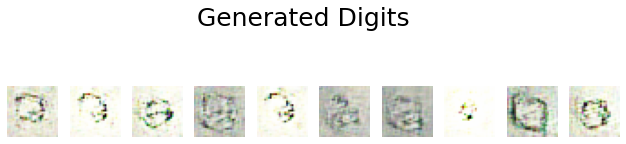

epoch:  661
discriminator loss:  0.6051687002182007
generator loss:  0.8428767323493958
--------------------------------------------------------------------------------
epoch:  662
discriminator loss:  0.46112072467803955
generator loss:  1.7204432487487793
--------------------------------------------------------------------------------
epoch:  663
discriminator loss:  0.47787562012672424
generator loss:  1.0417604446411133
--------------------------------------------------------------------------------
epoch:  664
discriminator loss:  0.4625369906425476
generator loss:  1.179909586906433
--------------------------------------------------------------------------------
epoch:  665
discriminator loss:  0.453694611787796
generator loss:  1.2231473922729492
--------------------------------------------------------------------------------


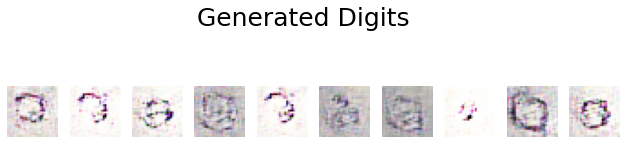

epoch:  666
discriminator loss:  0.4486273527145386
generator loss:  1.2457890510559082
--------------------------------------------------------------------------------
epoch:  667
discriminator loss:  0.43181362748146057
generator loss:  1.238755702972412
--------------------------------------------------------------------------------
epoch:  668
discriminator loss:  0.44499674439430237
generator loss:  1.3438754081726074
--------------------------------------------------------------------------------
epoch:  669
discriminator loss:  0.44042617082595825
generator loss:  0.9094535708427429
--------------------------------------------------------------------------------
epoch:  670
discriminator loss:  0.4339333474636078
generator loss:  1.469660758972168
--------------------------------------------------------------------------------


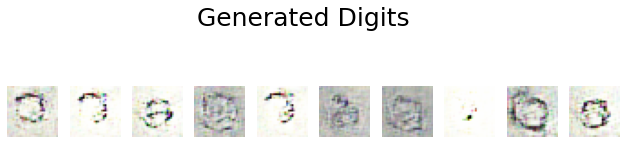

epoch:  671
discriminator loss:  0.43517112731933594
generator loss:  0.9329275488853455
--------------------------------------------------------------------------------
epoch:  672
discriminator loss:  0.45214608311653137
generator loss:  1.4566879272460938
--------------------------------------------------------------------------------
epoch:  673
discriminator loss:  0.43991973996162415
generator loss:  0.9182929992675781
--------------------------------------------------------------------------------
epoch:  674
discriminator loss:  0.4630540907382965
generator loss:  1.818601369857788
--------------------------------------------------------------------------------
epoch:  675
discriminator loss:  0.4855107367038727
generator loss:  0.5363086462020874
--------------------------------------------------------------------------------


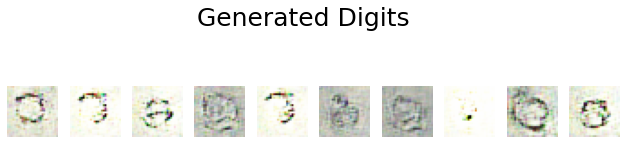

epoch:  676
discriminator loss:  0.5639698505401611
generator loss:  1.6057215929031372
--------------------------------------------------------------------------------
epoch:  677
discriminator loss:  0.43976521492004395
generator loss:  1.4013339281082153
--------------------------------------------------------------------------------
epoch:  678
discriminator loss:  0.4377502501010895
generator loss:  1.0240991115570068
--------------------------------------------------------------------------------
epoch:  679
discriminator loss:  0.4390759766101837
generator loss:  1.4260168075561523
--------------------------------------------------------------------------------
epoch:  680
discriminator loss:  0.4201773703098297
generator loss:  1.125818133354187
--------------------------------------------------------------------------------


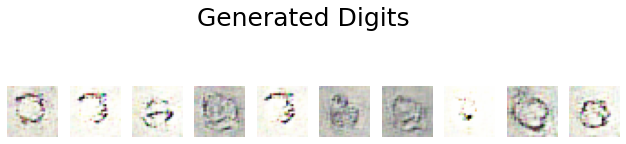

epoch:  681
discriminator loss:  0.4307478070259094
generator loss:  1.3991858959197998
--------------------------------------------------------------------------------
epoch:  682
discriminator loss:  0.4323180913925171
generator loss:  0.8617705702781677
--------------------------------------------------------------------------------
epoch:  683
discriminator loss:  0.4526710510253906
generator loss:  2.1514742374420166
--------------------------------------------------------------------------------
epoch:  684
discriminator loss:  0.5728192925453186
generator loss:  0.17564846575260162
--------------------------------------------------------------------------------
epoch:  685
discriminator loss:  0.9948104619979858
generator loss:  0.47792911529541016
--------------------------------------------------------------------------------


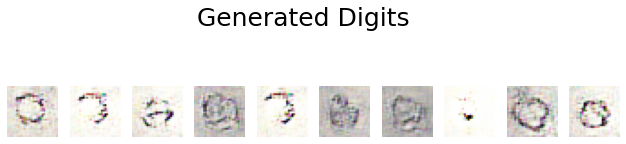

epoch:  686
discriminator loss:  0.6546043157577515
generator loss:  2.440833330154419
--------------------------------------------------------------------------------
epoch:  687
discriminator loss:  0.7399179339408875
generator loss:  0.7089887261390686
--------------------------------------------------------------------------------
epoch:  688
discriminator loss:  0.5283899307250977
generator loss:  0.7536857724189758
--------------------------------------------------------------------------------
epoch:  689
discriminator loss:  0.5288496017456055
generator loss:  1.2915868759155273
--------------------------------------------------------------------------------
epoch:  690
discriminator loss:  0.4726528823375702
generator loss:  1.3730895519256592
--------------------------------------------------------------------------------


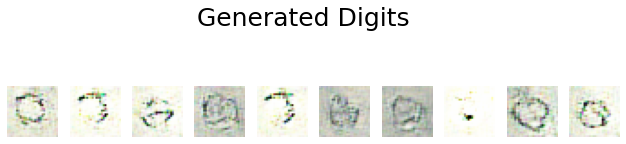

epoch:  691
discriminator loss:  0.48278939723968506
generator loss:  0.9657922983169556
--------------------------------------------------------------------------------
epoch:  692
discriminator loss:  0.4716030955314636
generator loss:  1.1218901872634888
--------------------------------------------------------------------------------
epoch:  693
discriminator loss:  0.4512104094028473
generator loss:  1.3192089796066284
--------------------------------------------------------------------------------
epoch:  694
discriminator loss:  0.4486336410045624
generator loss:  1.1076996326446533
--------------------------------------------------------------------------------
epoch:  695
discriminator loss:  0.44310420751571655
generator loss:  1.3799922466278076
--------------------------------------------------------------------------------


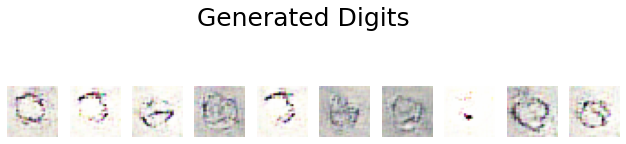

epoch:  696
discriminator loss:  0.4413381814956665
generator loss:  1.242112636566162
--------------------------------------------------------------------------------
epoch:  697
discriminator loss:  0.4377835988998413
generator loss:  1.1129024028778076
--------------------------------------------------------------------------------
epoch:  698
discriminator loss:  0.4295559823513031
generator loss:  1.250095248222351
--------------------------------------------------------------------------------
epoch:  699
discriminator loss:  0.42610272765159607
generator loss:  1.1783568859100342
--------------------------------------------------------------------------------
epoch:  700
discriminator loss:  0.4352922737598419
generator loss:  1.2524256706237793
--------------------------------------------------------------------------------


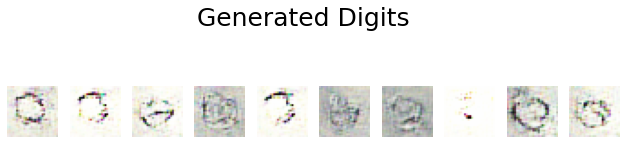

epoch:  701
discriminator loss:  0.4269348382949829
generator loss:  1.1607505083084106
--------------------------------------------------------------------------------
epoch:  702
discriminator loss:  0.41761934757232666
generator loss:  1.3205897808074951
--------------------------------------------------------------------------------
epoch:  703
discriminator loss:  0.4258251190185547
generator loss:  1.1173304319381714
--------------------------------------------------------------------------------
epoch:  704
discriminator loss:  0.4298710227012634
generator loss:  1.3341785669326782
--------------------------------------------------------------------------------
epoch:  705
discriminator loss:  0.4313395023345947
generator loss:  0.9262425303459167
--------------------------------------------------------------------------------


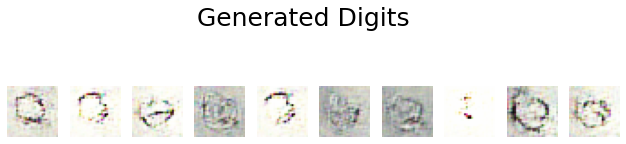

epoch:  706
discriminator loss:  0.4402949810028076
generator loss:  1.719213843345642
--------------------------------------------------------------------------------
epoch:  707
discriminator loss:  0.49334439635276794
generator loss:  0.33428019285202026
--------------------------------------------------------------------------------
epoch:  708
discriminator loss:  0.8009414076805115
generator loss:  1.1934285163879395
--------------------------------------------------------------------------------
epoch:  709
discriminator loss:  0.45198559761047363
generator loss:  2.0560522079467773
--------------------------------------------------------------------------------
epoch:  710
discriminator loss:  0.5772894024848938
generator loss:  0.47270992398262024
--------------------------------------------------------------------------------


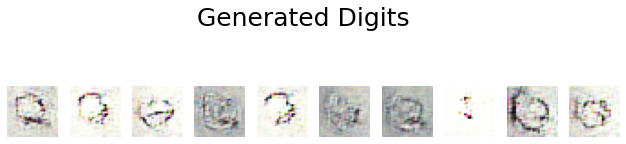

epoch:  711
discriminator loss:  0.6264643669128418
generator loss:  0.9432655572891235
--------------------------------------------------------------------------------
epoch:  712
discriminator loss:  0.44465532898902893
generator loss:  1.9490907192230225
--------------------------------------------------------------------------------
epoch:  713
discriminator loss:  0.5306962728500366
generator loss:  0.754123330116272
--------------------------------------------------------------------------------
epoch:  714
discriminator loss:  0.4984464645385742
generator loss:  1.0733026266098022
--------------------------------------------------------------------------------
epoch:  715
discriminator loss:  0.43683701753616333
generator loss:  1.7253495454788208
--------------------------------------------------------------------------------


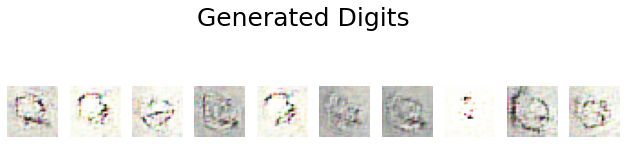

epoch:  716
discriminator loss:  0.4602648615837097
generator loss:  0.9162123203277588
--------------------------------------------------------------------------------
epoch:  717
discriminator loss:  0.44729697704315186
generator loss:  1.2439990043640137
--------------------------------------------------------------------------------
epoch:  718
discriminator loss:  0.4082404673099518
generator loss:  1.5969685316085815
--------------------------------------------------------------------------------
epoch:  719
discriminator loss:  0.44253718852996826
generator loss:  0.9921114444732666
--------------------------------------------------------------------------------
epoch:  720
discriminator loss:  0.4300118684768677
generator loss:  1.518542766571045
--------------------------------------------------------------------------------


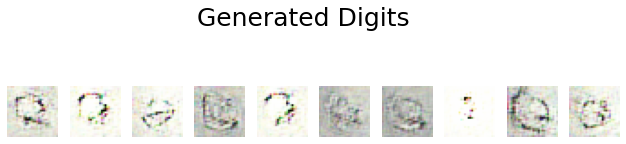

epoch:  721
discriminator loss:  0.42603549361228943
generator loss:  1.2654361724853516
--------------------------------------------------------------------------------
epoch:  722
discriminator loss:  0.41424164175987244
generator loss:  1.379118800163269
--------------------------------------------------------------------------------
epoch:  723
discriminator loss:  0.40422290563583374
generator loss:  1.599125862121582
--------------------------------------------------------------------------------
epoch:  724
discriminator loss:  0.42503848671913147
generator loss:  0.8712210655212402
--------------------------------------------------------------------------------
epoch:  725
discriminator loss:  0.45220860838890076
generator loss:  1.9434467554092407
--------------------------------------------------------------------------------


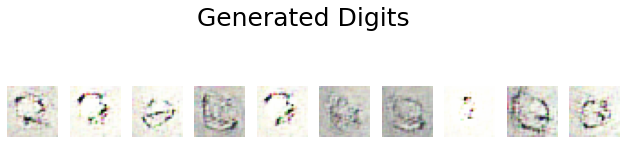

epoch:  726
discriminator loss:  0.45779523253440857
generator loss:  0.5413364171981812
--------------------------------------------------------------------------------
epoch:  727
discriminator loss:  0.5695685744285583
generator loss:  1.5101317167282104
--------------------------------------------------------------------------------
epoch:  728
discriminator loss:  0.41905441880226135
generator loss:  1.602940320968628
--------------------------------------------------------------------------------
epoch:  729
discriminator loss:  0.43098804354667664
generator loss:  0.8508606553077698
--------------------------------------------------------------------------------
epoch:  730
discriminator loss:  0.4453844428062439
generator loss:  1.6000698804855347
--------------------------------------------------------------------------------


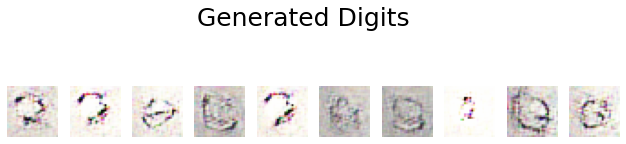

epoch:  731
discriminator loss:  0.4062268137931824
generator loss:  1.455662488937378
--------------------------------------------------------------------------------
epoch:  732
discriminator loss:  0.4208466708660126
generator loss:  1.0292510986328125
--------------------------------------------------------------------------------
epoch:  733
discriminator loss:  0.4328848719596863
generator loss:  1.9436497688293457
--------------------------------------------------------------------------------
epoch:  734
discriminator loss:  0.4492661654949188
generator loss:  0.5924093723297119
--------------------------------------------------------------------------------
epoch:  735
discriminator loss:  0.5732884407043457
generator loss:  1.9600844383239746
--------------------------------------------------------------------------------


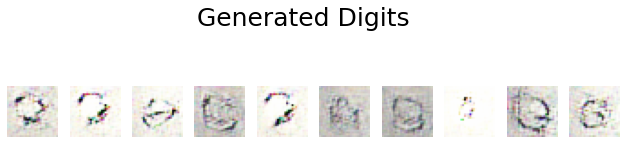

epoch:  736
discriminator loss:  0.47935494780540466
generator loss:  0.7335205078125
--------------------------------------------------------------------------------
epoch:  737
discriminator loss:  0.48406192660331726
generator loss:  1.534656047821045
--------------------------------------------------------------------------------
epoch:  738
discriminator loss:  0.41498497128486633
generator loss:  1.7085689306259155
--------------------------------------------------------------------------------
epoch:  739
discriminator loss:  0.44084233045578003
generator loss:  0.8640773296356201
--------------------------------------------------------------------------------
epoch:  740
discriminator loss:  0.4680134654045105
generator loss:  1.839828372001648
--------------------------------------------------------------------------------


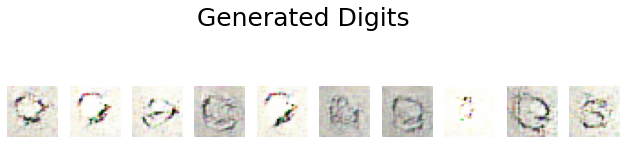

epoch:  741
discriminator loss:  0.44824284315109253
generator loss:  0.9927501082420349
--------------------------------------------------------------------------------
epoch:  742
discriminator loss:  0.4392569363117218
generator loss:  1.6013511419296265
--------------------------------------------------------------------------------
epoch:  743
discriminator loss:  0.4161358177661896
generator loss:  1.2567168474197388
--------------------------------------------------------------------------------
epoch:  744
discriminator loss:  0.4252481460571289
generator loss:  1.7045598030090332
--------------------------------------------------------------------------------
epoch:  745
discriminator loss:  0.4067668616771698
generator loss:  0.9932326674461365
--------------------------------------------------------------------------------


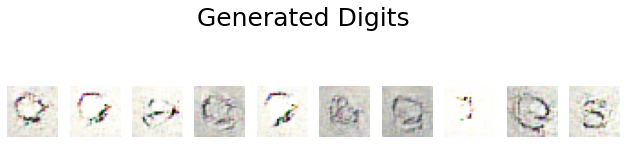

epoch:  746
discriminator loss:  0.45285362005233765
generator loss:  2.120481014251709
--------------------------------------------------------------------------------
epoch:  747
discriminator loss:  0.4956936538219452
generator loss:  0.31612175703048706
--------------------------------------------------------------------------------
epoch:  748
discriminator loss:  0.7728118300437927
generator loss:  1.201102375984192
--------------------------------------------------------------------------------
epoch:  749
discriminator loss:  0.4342396855354309
generator loss:  2.257221221923828
--------------------------------------------------------------------------------
epoch:  750
discriminator loss:  0.5857623815536499
generator loss:  0.508151650428772
--------------------------------------------------------------------------------


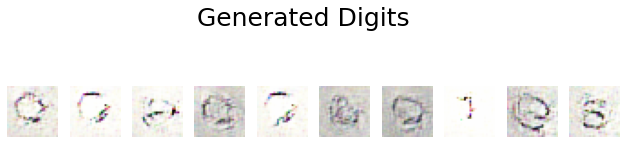

epoch:  751
discriminator loss:  0.6125575304031372
generator loss:  0.9719630479812622
--------------------------------------------------------------------------------
epoch:  752
discriminator loss:  0.4526296854019165
generator loss:  2.0249440670013428
--------------------------------------------------------------------------------
epoch:  753
discriminator loss:  0.5313783884048462
generator loss:  0.8518047332763672
--------------------------------------------------------------------------------
epoch:  754
discriminator loss:  0.48393258452415466
generator loss:  1.0715082883834839
--------------------------------------------------------------------------------
epoch:  755
discriminator loss:  0.4347809851169586
generator loss:  1.6057182550430298
--------------------------------------------------------------------------------


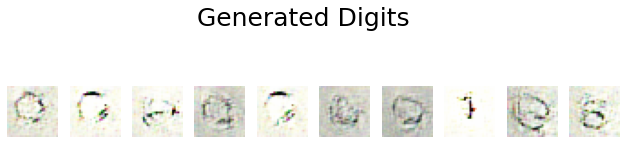

epoch:  756
discriminator loss:  0.4326398968696594
generator loss:  1.3489508628845215
--------------------------------------------------------------------------------
epoch:  757
discriminator loss:  0.4368683695793152
generator loss:  1.252476692199707
--------------------------------------------------------------------------------
epoch:  758
discriminator loss:  0.4296589195728302
generator loss:  1.426694631576538
--------------------------------------------------------------------------------
epoch:  759
discriminator loss:  0.4257594048976898
generator loss:  1.3553012609481812
--------------------------------------------------------------------------------
epoch:  760
discriminator loss:  0.4341121017932892
generator loss:  1.5684258937835693
--------------------------------------------------------------------------------


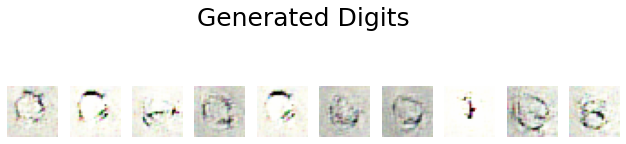

epoch:  761
discriminator loss:  0.4260500967502594
generator loss:  1.116653561592102
--------------------------------------------------------------------------------
epoch:  762
discriminator loss:  0.4330308139324188
generator loss:  1.8929812908172607
--------------------------------------------------------------------------------
epoch:  763
discriminator loss:  0.4492190182209015
generator loss:  0.6539256572723389
--------------------------------------------------------------------------------
epoch:  764
discriminator loss:  0.5602356195449829
generator loss:  2.0977590084075928
--------------------------------------------------------------------------------
epoch:  765
discriminator loss:  0.48422256112098694
generator loss:  0.7975842356681824
--------------------------------------------------------------------------------


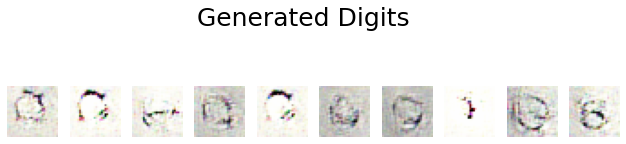

epoch:  766
discriminator loss:  0.49304133653640747
generator loss:  1.5706090927124023
--------------------------------------------------------------------------------
epoch:  767
discriminator loss:  0.42643964290618896
generator loss:  1.693148136138916
--------------------------------------------------------------------------------
epoch:  768
discriminator loss:  0.4227347671985626
generator loss:  1.1929998397827148
--------------------------------------------------------------------------------
epoch:  769
discriminator loss:  0.42394405603408813
generator loss:  1.481361985206604
--------------------------------------------------------------------------------
epoch:  770
discriminator loss:  0.40573254227638245
generator loss:  1.4031659364700317
--------------------------------------------------------------------------------


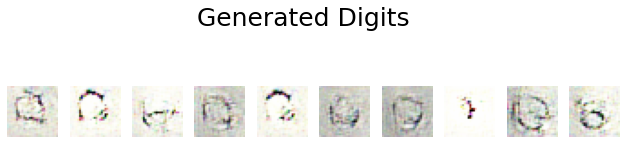

epoch:  771
discriminator loss:  0.4044494926929474
generator loss:  1.5155411958694458
--------------------------------------------------------------------------------
epoch:  772
discriminator loss:  0.4075016677379608
generator loss:  1.1560560464859009
--------------------------------------------------------------------------------
epoch:  773
discriminator loss:  0.40614384412765503
generator loss:  1.4743636846542358
--------------------------------------------------------------------------------
epoch:  774
discriminator loss:  0.4127751290798187
generator loss:  1.2063062191009521
--------------------------------------------------------------------------------
epoch:  775
discriminator loss:  0.3959532082080841
generator loss:  1.6470333337783813
--------------------------------------------------------------------------------


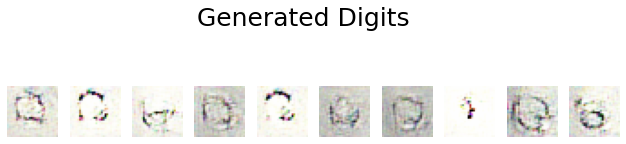

epoch:  776
discriminator loss:  0.4018789231777191
generator loss:  0.9650514721870422
--------------------------------------------------------------------------------
epoch:  777
discriminator loss:  0.43983346223831177
generator loss:  2.3786516189575195
--------------------------------------------------------------------------------
epoch:  778
discriminator loss:  0.5374436378479004
generator loss:  0.16371077299118042
--------------------------------------------------------------------------------
epoch:  779
discriminator loss:  1.0093414783477783
generator loss:  0.4894433319568634
--------------------------------------------------------------------------------
epoch:  780
discriminator loss:  0.6446182727813721
generator loss:  2.356945276260376
--------------------------------------------------------------------------------


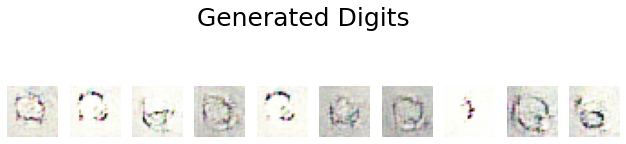

epoch:  781
discriminator loss:  0.6883934140205383
generator loss:  0.9655761122703552
--------------------------------------------------------------------------------
epoch:  782
discriminator loss:  0.4708769917488098
generator loss:  0.8673826456069946
--------------------------------------------------------------------------------
epoch:  783
discriminator loss:  0.4827035963535309
generator loss:  1.3362361192703247
--------------------------------------------------------------------------------
epoch:  784
discriminator loss:  0.4791136085987091
generator loss:  1.4180508852005005
--------------------------------------------------------------------------------
epoch:  785
discriminator loss:  0.46650248765945435
generator loss:  1.109043002128601
--------------------------------------------------------------------------------


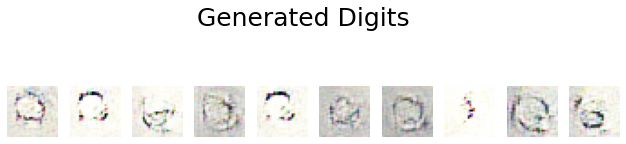

epoch:  786
discriminator loss:  0.44213443994522095
generator loss:  1.2849183082580566
--------------------------------------------------------------------------------
epoch:  787
discriminator loss:  0.44260552525520325
generator loss:  1.303817629814148
--------------------------------------------------------------------------------
epoch:  788
discriminator loss:  0.43381544947624207
generator loss:  1.3307418823242188
--------------------------------------------------------------------------------
epoch:  789
discriminator loss:  0.44087082147598267
generator loss:  1.1619236469268799
--------------------------------------------------------------------------------
epoch:  790
discriminator loss:  0.4256362020969391
generator loss:  1.5011155605316162
--------------------------------------------------------------------------------


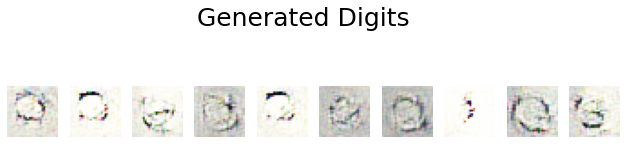

epoch:  791
discriminator loss:  0.43272197246551514
generator loss:  1.0374462604522705
--------------------------------------------------------------------------------
epoch:  792
discriminator loss:  0.4213377833366394
generator loss:  1.6403459310531616
--------------------------------------------------------------------------------
epoch:  793
discriminator loss:  0.4395449161529541
generator loss:  0.8510385751724243
--------------------------------------------------------------------------------
epoch:  794
discriminator loss:  0.4801149070262909
generator loss:  2.143881320953369
--------------------------------------------------------------------------------
epoch:  795
discriminator loss:  0.4759954512119293
generator loss:  0.5706458687782288
--------------------------------------------------------------------------------


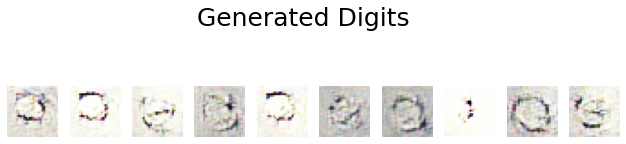

epoch:  796
discriminator loss:  0.5877872109413147
generator loss:  1.8297566175460815
--------------------------------------------------------------------------------
epoch:  797
discriminator loss:  0.4464530944824219
generator loss:  1.4234743118286133
--------------------------------------------------------------------------------
epoch:  798
discriminator loss:  0.4235730469226837
generator loss:  1.2060575485229492
--------------------------------------------------------------------------------
epoch:  799
discriminator loss:  0.41740715503692627
generator loss:  1.6741611957550049
--------------------------------------------------------------------------------
epoch:  800
discriminator loss:  0.4121216833591461
generator loss:  1.3231208324432373
--------------------------------------------------------------------------------


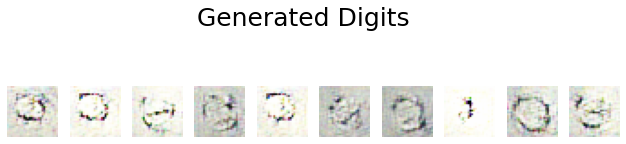

epoch:  801
discriminator loss:  0.39748015999794006
generator loss:  1.4228826761245728
--------------------------------------------------------------------------------
epoch:  802
discriminator loss:  0.4013861417770386
generator loss:  1.4178966283798218
--------------------------------------------------------------------------------
epoch:  803
discriminator loss:  0.3972410559654236
generator loss:  1.4169082641601562
--------------------------------------------------------------------------------
epoch:  804
discriminator loss:  0.39936867356300354
generator loss:  1.595055341720581
--------------------------------------------------------------------------------
epoch:  805
discriminator loss:  0.3973273038864136
generator loss:  1.162021279335022
--------------------------------------------------------------------------------


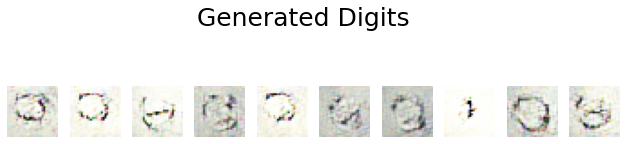

epoch:  806
discriminator loss:  0.40158748626708984
generator loss:  1.9191465377807617
--------------------------------------------------------------------------------
epoch:  807
discriminator loss:  0.428783118724823
generator loss:  0.5701010823249817
--------------------------------------------------------------------------------
epoch:  808
discriminator loss:  0.5705302953720093
generator loss:  2.4758365154266357
--------------------------------------------------------------------------------
epoch:  809
discriminator loss:  0.5265577435493469
generator loss:  0.4189288318157196
--------------------------------------------------------------------------------
epoch:  810
discriminator loss:  0.6676000952720642
generator loss:  1.6041374206542969
--------------------------------------------------------------------------------


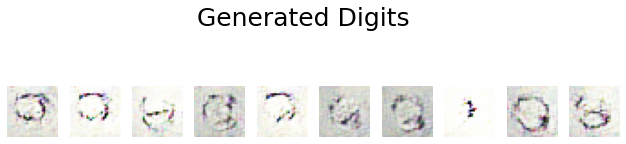

epoch:  811
discriminator loss:  0.41822394728660583
generator loss:  1.8444054126739502
--------------------------------------------------------------------------------
epoch:  812
discriminator loss:  0.45741981267929077
generator loss:  0.9208709001541138
--------------------------------------------------------------------------------
epoch:  813
discriminator loss:  0.45935967564582825
generator loss:  1.4930243492126465
--------------------------------------------------------------------------------
epoch:  814
discriminator loss:  0.4317902624607086
generator loss:  1.4806904792785645
--------------------------------------------------------------------------------
epoch:  815
discriminator loss:  0.42246586084365845
generator loss:  1.016208529472351
--------------------------------------------------------------------------------


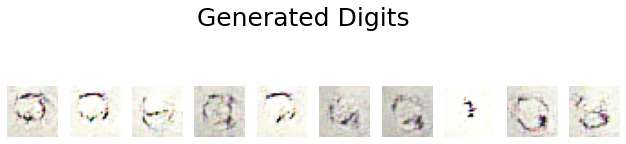

epoch:  816
discriminator loss:  0.43481647968292236
generator loss:  1.7225871086120605
--------------------------------------------------------------------------------
epoch:  817
discriminator loss:  0.43048492074012756
generator loss:  1.081260323524475
--------------------------------------------------------------------------------
epoch:  818
discriminator loss:  0.4098806381225586
generator loss:  1.4898898601531982
--------------------------------------------------------------------------------
epoch:  819
discriminator loss:  0.404928058385849
generator loss:  1.249008297920227
--------------------------------------------------------------------------------
epoch:  820
discriminator loss:  0.41111743450164795
generator loss:  1.5562254190444946
--------------------------------------------------------------------------------


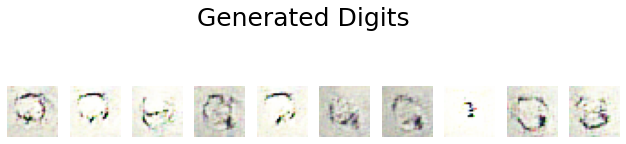

epoch:  821
discriminator loss:  0.4037274420261383
generator loss:  1.0678019523620605
--------------------------------------------------------------------------------
epoch:  822
discriminator loss:  0.4161710739135742
generator loss:  1.7403483390808105
--------------------------------------------------------------------------------
epoch:  823
discriminator loss:  0.4295276701450348
generator loss:  0.7217637896537781
--------------------------------------------------------------------------------
epoch:  824
discriminator loss:  0.473554790019989
generator loss:  1.8964755535125732
--------------------------------------------------------------------------------
epoch:  825
discriminator loss:  0.42496761679649353
generator loss:  0.8348230123519897
--------------------------------------------------------------------------------


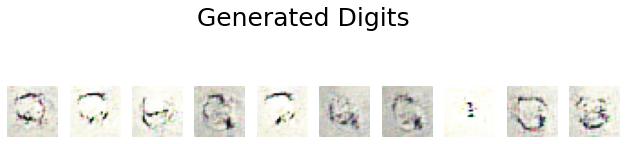

epoch:  826
discriminator loss:  0.45764899253845215
generator loss:  1.846028447151184
--------------------------------------------------------------------------------
epoch:  827
discriminator loss:  0.4212735891342163
generator loss:  1.0262662172317505
--------------------------------------------------------------------------------
epoch:  828
discriminator loss:  0.4239322543144226
generator loss:  1.4924044609069824
--------------------------------------------------------------------------------
epoch:  829
discriminator loss:  0.39241793751716614
generator loss:  1.6389046907424927
--------------------------------------------------------------------------------
epoch:  830
discriminator loss:  0.3990979790687561
generator loss:  1.103226900100708
--------------------------------------------------------------------------------


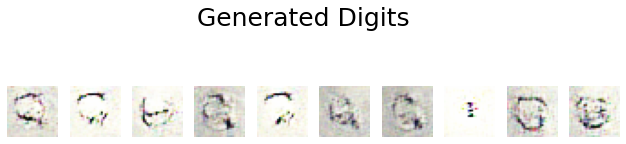

epoch:  831
discriminator loss:  0.41779521107673645
generator loss:  1.7783174514770508
--------------------------------------------------------------------------------
epoch:  832
discriminator loss:  0.3985211253166199
generator loss:  1.0652433633804321
--------------------------------------------------------------------------------
epoch:  833
discriminator loss:  0.40526852011680603
generator loss:  1.786553144454956
--------------------------------------------------------------------------------
epoch:  834
discriminator loss:  0.40101200342178345
generator loss:  0.9252313375473022
--------------------------------------------------------------------------------
epoch:  835
discriminator loss:  0.4393310546875
generator loss:  2.2478065490722656
--------------------------------------------------------------------------------


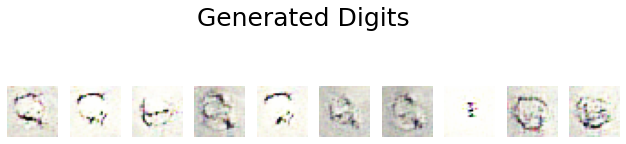

epoch:  836
discriminator loss:  0.4611376225948334
generator loss:  0.5458374619483948
--------------------------------------------------------------------------------
epoch:  837
discriminator loss:  0.6037343144416809
generator loss:  2.2002501487731934
--------------------------------------------------------------------------------
epoch:  838
discriminator loss:  0.4513035714626312
generator loss:  1.1725795269012451
--------------------------------------------------------------------------------
epoch:  839
discriminator loss:  0.40442657470703125
generator loss:  1.2498388290405273
--------------------------------------------------------------------------------
epoch:  840
discriminator loss:  0.41033145785331726
generator loss:  1.76509690284729
--------------------------------------------------------------------------------


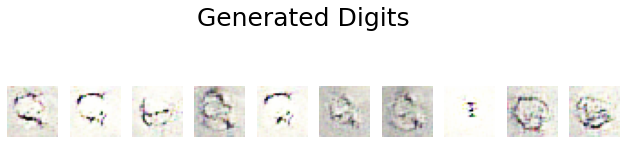

epoch:  841
discriminator loss:  0.4044504463672638
generator loss:  1.2095539569854736
--------------------------------------------------------------------------------
epoch:  842
discriminator loss:  0.4016557037830353
generator loss:  1.534264326095581
--------------------------------------------------------------------------------
epoch:  843
discriminator loss:  0.3990840017795563
generator loss:  1.427781105041504
--------------------------------------------------------------------------------
epoch:  844
discriminator loss:  0.3965821862220764
generator loss:  1.350777268409729
--------------------------------------------------------------------------------
epoch:  845
discriminator loss:  0.3942645192146301
generator loss:  1.5743175745010376
--------------------------------------------------------------------------------


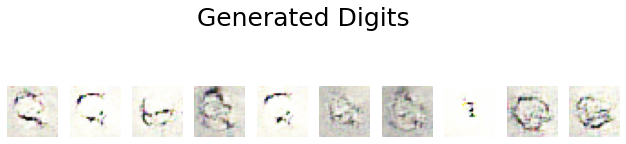

epoch:  846
discriminator loss:  0.39832696318626404
generator loss:  1.2557629346847534
--------------------------------------------------------------------------------
epoch:  847
discriminator loss:  0.39639556407928467
generator loss:  1.5997133255004883
--------------------------------------------------------------------------------
epoch:  848
discriminator loss:  0.39697593450546265
generator loss:  1.0775561332702637
--------------------------------------------------------------------------------
epoch:  849
discriminator loss:  0.40772467851638794
generator loss:  2.3743724822998047
--------------------------------------------------------------------------------
epoch:  850
discriminator loss:  0.5090165138244629
generator loss:  0.15491937100887299
--------------------------------------------------------------------------------


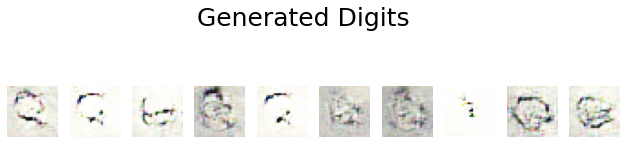

epoch:  851
discriminator loss:  1.0129977464675903
generator loss:  0.7720626592636108
--------------------------------------------------------------------------------
epoch:  852
discriminator loss:  0.526335597038269
generator loss:  2.9501748085021973
--------------------------------------------------------------------------------
epoch:  853
discriminator loss:  0.7658458948135376
generator loss:  0.6283261179924011
--------------------------------------------------------------------------------
epoch:  854
discriminator loss:  0.5131550431251526
generator loss:  0.8112665414810181
--------------------------------------------------------------------------------
epoch:  855
discriminator loss:  0.46648964285850525
generator loss:  1.7183729410171509
--------------------------------------------------------------------------------


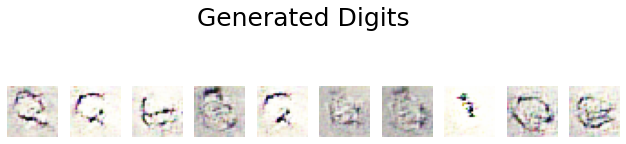

epoch:  856
discriminator loss:  0.44541701674461365
generator loss:  1.2191506624221802
--------------------------------------------------------------------------------
epoch:  857
discriminator loss:  0.40879151225090027
generator loss:  1.0160038471221924
--------------------------------------------------------------------------------
epoch:  858
discriminator loss:  0.4226505756378174
generator loss:  1.3167780637741089
--------------------------------------------------------------------------------
epoch:  859
discriminator loss:  0.4087512195110321
generator loss:  1.3847182989120483
--------------------------------------------------------------------------------
epoch:  860
discriminator loss:  0.41166526079177856
generator loss:  1.2496546506881714
--------------------------------------------------------------------------------


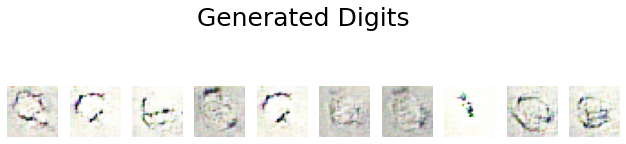

epoch:  861
discriminator loss:  0.40481844544410706
generator loss:  1.5633964538574219
--------------------------------------------------------------------------------
epoch:  862
discriminator loss:  0.4064413011074066
generator loss:  1.122556209564209
--------------------------------------------------------------------------------
epoch:  863
discriminator loss:  0.4093194305896759
generator loss:  1.5853685140609741
--------------------------------------------------------------------------------
epoch:  864
discriminator loss:  0.4142813980579376
generator loss:  1.0461623668670654
--------------------------------------------------------------------------------
epoch:  865
discriminator loss:  0.41613513231277466
generator loss:  2.0698671340942383
--------------------------------------------------------------------------------


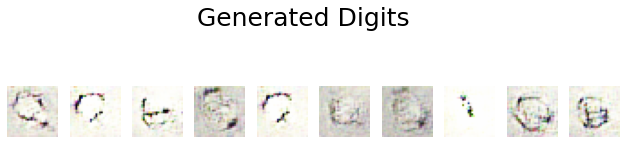

epoch:  866
discriminator loss:  0.4620803892612457
generator loss:  0.4118555784225464
--------------------------------------------------------------------------------
epoch:  867
discriminator loss:  0.6509549021720886
generator loss:  1.7124838829040527
--------------------------------------------------------------------------------
epoch:  868
discriminator loss:  0.42022454738616943
generator loss:  1.6925173997879028
--------------------------------------------------------------------------------
epoch:  869
discriminator loss:  0.41171056032180786
generator loss:  1.1293883323669434
--------------------------------------------------------------------------------
epoch:  870
discriminator loss:  0.4181221127510071
generator loss:  1.6669572591781616
--------------------------------------------------------------------------------


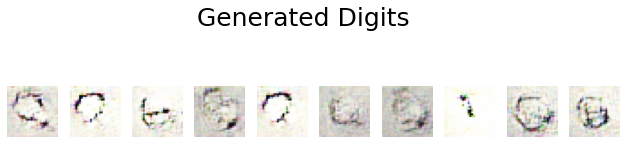

epoch:  871
discriminator loss:  0.404989093542099
generator loss:  1.4258767366409302
--------------------------------------------------------------------------------
epoch:  872
discriminator loss:  0.38708260655403137
generator loss:  1.403062343597412
--------------------------------------------------------------------------------
epoch:  873
discriminator loss:  0.38726723194122314
generator loss:  1.5145183801651
--------------------------------------------------------------------------------
epoch:  874
discriminator loss:  0.3990544080734253
generator loss:  1.2304707765579224
--------------------------------------------------------------------------------
epoch:  875
discriminator loss:  0.3985191285610199
generator loss:  1.8259689807891846
--------------------------------------------------------------------------------


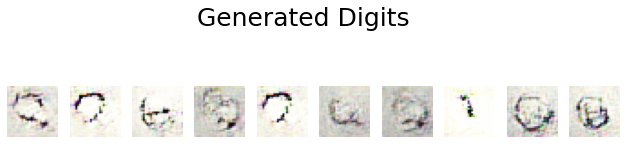

epoch:  876
discriminator loss:  0.4084772765636444
generator loss:  0.8345322608947754
--------------------------------------------------------------------------------
epoch:  877
discriminator loss:  0.45842280983924866
generator loss:  2.4565699100494385
--------------------------------------------------------------------------------
epoch:  878
discriminator loss:  0.49879559874534607
generator loss:  0.3188314139842987
--------------------------------------------------------------------------------
epoch:  879
discriminator loss:  0.7506623268127441
generator loss:  1.4380826950073242
--------------------------------------------------------------------------------
epoch:  880
discriminator loss:  0.418061226606369
generator loss:  2.247175931930542
--------------------------------------------------------------------------------


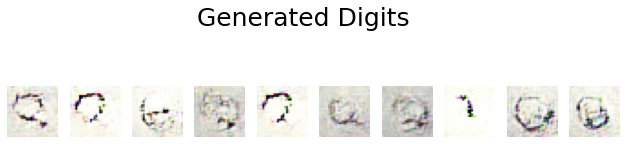

epoch:  881
discriminator loss:  0.4964626729488373
generator loss:  0.7755146026611328
--------------------------------------------------------------------------------
epoch:  882
discriminator loss:  0.48075705766677856
generator loss:  1.1691163778305054
--------------------------------------------------------------------------------
epoch:  883
discriminator loss:  0.4171285927295685
generator loss:  1.8881901502609253
--------------------------------------------------------------------------------
epoch:  884
discriminator loss:  0.4463930130004883
generator loss:  1.1028811931610107
--------------------------------------------------------------------------------
epoch:  885
discriminator loss:  0.4098455011844635
generator loss:  1.2231714725494385
--------------------------------------------------------------------------------


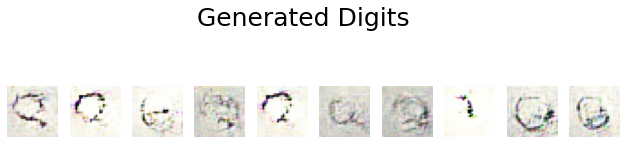

epoch:  886
discriminator loss:  0.39839720726013184
generator loss:  1.5822992324829102
--------------------------------------------------------------------------------
epoch:  887
discriminator loss:  0.4011283814907074
generator loss:  1.2211507558822632
--------------------------------------------------------------------------------
epoch:  888
discriminator loss:  0.4015164077281952
generator loss:  1.438258171081543
--------------------------------------------------------------------------------
epoch:  889
discriminator loss:  0.4033893644809723
generator loss:  1.3998855352401733
--------------------------------------------------------------------------------
epoch:  890
discriminator loss:  0.3893236219882965
generator loss:  1.2662808895111084
--------------------------------------------------------------------------------


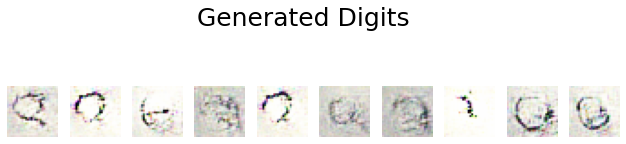

epoch:  891
discriminator loss:  0.4126366674900055
generator loss:  1.8648723363876343
--------------------------------------------------------------------------------
epoch:  892
discriminator loss:  0.436320960521698
generator loss:  0.48069289326667786
--------------------------------------------------------------------------------
epoch:  893
discriminator loss:  0.6140610575675964
generator loss:  1.845842719078064
--------------------------------------------------------------------------------
epoch:  894
discriminator loss:  0.43587982654571533
generator loss:  1.4734095335006714
--------------------------------------------------------------------------------
epoch:  895
discriminator loss:  0.4170834422111511
generator loss:  1.2918986082077026
--------------------------------------------------------------------------------


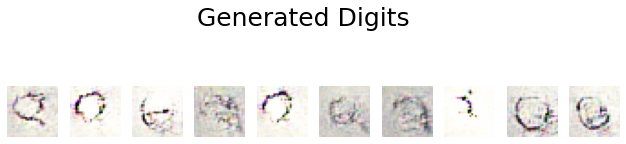

epoch:  896
discriminator loss:  0.40505120158195496
generator loss:  1.692832589149475
--------------------------------------------------------------------------------
epoch:  897
discriminator loss:  0.3923993706703186
generator loss:  1.2619845867156982
--------------------------------------------------------------------------------
epoch:  898
discriminator loss:  0.40818336606025696
generator loss:  1.5979623794555664
--------------------------------------------------------------------------------
epoch:  899
discriminator loss:  0.3979695439338684
generator loss:  1.4063812494277954
--------------------------------------------------------------------------------
epoch:  900
discriminator loss:  0.3919419050216675
generator loss:  1.436373233795166
--------------------------------------------------------------------------------


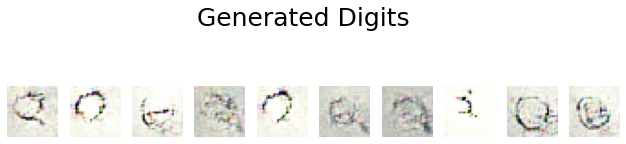

epoch:  901
discriminator loss:  0.38502055406570435
generator loss:  1.6077107191085815
--------------------------------------------------------------------------------
epoch:  902
discriminator loss:  0.3961246609687805
generator loss:  1.3353101015090942
--------------------------------------------------------------------------------
epoch:  903
discriminator loss:  0.38979873061180115
generator loss:  1.6190974712371826
--------------------------------------------------------------------------------
epoch:  904
discriminator loss:  0.40394195914268494
generator loss:  0.9492793083190918
--------------------------------------------------------------------------------
epoch:  905
discriminator loss:  0.44636455178260803
generator loss:  2.5074846744537354
--------------------------------------------------------------------------------


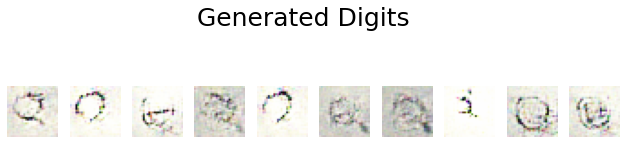

epoch:  906
discriminator loss:  0.5188650488853455
generator loss:  0.2076251357793808
--------------------------------------------------------------------------------
epoch:  907
discriminator loss:  0.9589501023292542
generator loss:  0.8556878566741943
--------------------------------------------------------------------------------
epoch:  908
discriminator loss:  0.48227328062057495
generator loss:  2.5595719814300537
--------------------------------------------------------------------------------
epoch:  909
discriminator loss:  0.666721522808075
generator loss:  0.7599630951881409
--------------------------------------------------------------------------------
epoch:  910
discriminator loss:  0.49806442856788635
generator loss:  0.904738187789917
--------------------------------------------------------------------------------


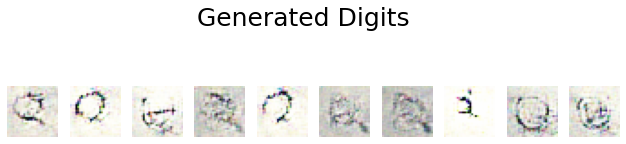

epoch:  911
discriminator loss:  0.45105645060539246
generator loss:  1.5472804307937622
--------------------------------------------------------------------------------
epoch:  912
discriminator loss:  0.42349833250045776
generator loss:  1.5417513847351074
--------------------------------------------------------------------------------
epoch:  913
discriminator loss:  0.43070441484451294
generator loss:  1.1223080158233643
--------------------------------------------------------------------------------
epoch:  914
discriminator loss:  0.40834468603134155
generator loss:  1.1988170146942139
--------------------------------------------------------------------------------
epoch:  915
discriminator loss:  0.4220786690711975
generator loss:  1.5268512964248657
--------------------------------------------------------------------------------


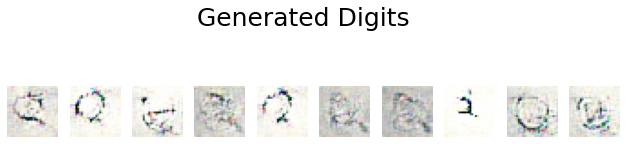

epoch:  916
discriminator loss:  0.4175409972667694
generator loss:  1.2398622035980225
--------------------------------------------------------------------------------
epoch:  917
discriminator loss:  0.4128870368003845
generator loss:  1.4503957033157349
--------------------------------------------------------------------------------
epoch:  918
discriminator loss:  0.415862113237381
generator loss:  1.373258113861084
--------------------------------------------------------------------------------
epoch:  919
discriminator loss:  0.4036997854709625
generator loss:  1.2405750751495361
--------------------------------------------------------------------------------
epoch:  920
discriminator loss:  0.4125151038169861
generator loss:  1.5870524644851685
--------------------------------------------------------------------------------


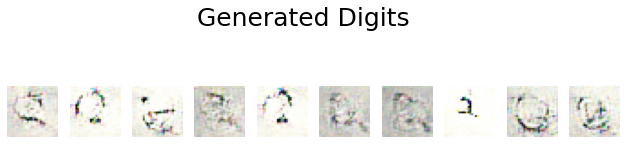

epoch:  921
discriminator loss:  0.41339945793151855
generator loss:  1.1265841722488403
--------------------------------------------------------------------------------
epoch:  922
discriminator loss:  0.41048285365104675
generator loss:  1.9387078285217285
--------------------------------------------------------------------------------
epoch:  923
discriminator loss:  0.416327565908432
generator loss:  0.6716158390045166
--------------------------------------------------------------------------------
epoch:  924
discriminator loss:  0.5393353700637817
generator loss:  2.695326566696167
--------------------------------------------------------------------------------
epoch:  925
discriminator loss:  0.582598090171814
generator loss:  0.26276496052742004
--------------------------------------------------------------------------------


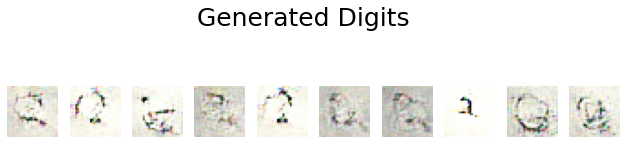

epoch:  926
discriminator loss:  0.8656860589981079
generator loss:  0.8612016439437866
--------------------------------------------------------------------------------
epoch:  927
discriminator loss:  0.4757857620716095
generator loss:  2.455688238143921
--------------------------------------------------------------------------------
epoch:  928
discriminator loss:  0.5746625661849976
generator loss:  1.072295069694519
--------------------------------------------------------------------------------
epoch:  929
discriminator loss:  0.4372078776359558
generator loss:  1.0754356384277344
--------------------------------------------------------------------------------
epoch:  930
discriminator loss:  0.4448074996471405
generator loss:  1.7811511754989624
--------------------------------------------------------------------------------


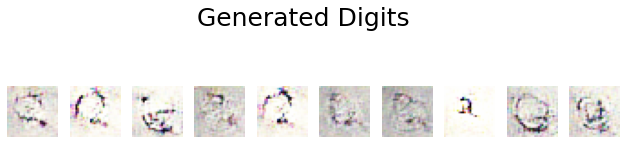

epoch:  931
discriminator loss:  0.417836457490921
generator loss:  1.5902338027954102
--------------------------------------------------------------------------------
epoch:  932
discriminator loss:  0.3969184458255768
generator loss:  1.2964444160461426
--------------------------------------------------------------------------------
epoch:  933
discriminator loss:  0.3911702632904053
generator loss:  1.5811576843261719
--------------------------------------------------------------------------------
epoch:  934
discriminator loss:  0.39382994174957275
generator loss:  1.6358166933059692
--------------------------------------------------------------------------------
epoch:  935
discriminator loss:  0.385331928730011
generator loss:  1.3111968040466309
--------------------------------------------------------------------------------


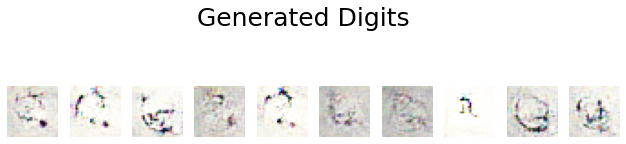

epoch:  936
discriminator loss:  0.3988533020019531
generator loss:  1.7437469959259033
--------------------------------------------------------------------------------
epoch:  937
discriminator loss:  0.3901057839393616
generator loss:  1.3019707202911377
--------------------------------------------------------------------------------
epoch:  938
discriminator loss:  0.397162526845932
generator loss:  1.533546805381775
--------------------------------------------------------------------------------
epoch:  939
discriminator loss:  0.3895482122898102
generator loss:  1.5433366298675537
--------------------------------------------------------------------------------
epoch:  940
discriminator loss:  0.4005128741264343
generator loss:  1.4319583177566528
--------------------------------------------------------------------------------


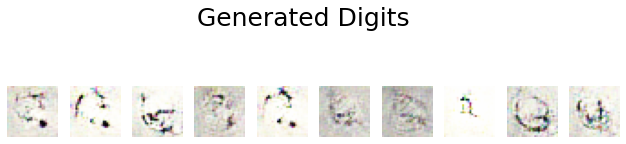

epoch:  941
discriminator loss:  0.39524227380752563
generator loss:  1.436189889907837
--------------------------------------------------------------------------------
epoch:  942
discriminator loss:  0.3899688422679901
generator loss:  1.565628170967102
--------------------------------------------------------------------------------
epoch:  943
discriminator loss:  0.39826229214668274
generator loss:  1.196367859840393
--------------------------------------------------------------------------------
epoch:  944
discriminator loss:  0.4086241126060486
generator loss:  2.244331121444702
--------------------------------------------------------------------------------
epoch:  945
discriminator loss:  0.4512799084186554
generator loss:  0.41220131516456604
--------------------------------------------------------------------------------


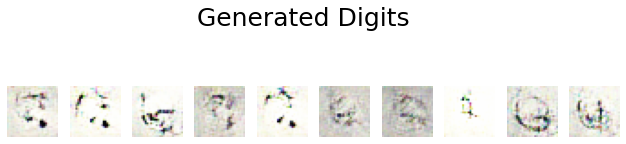

epoch:  946
discriminator loss:  0.6731249094009399
generator loss:  1.7888838052749634
--------------------------------------------------------------------------------
epoch:  947
discriminator loss:  0.42721378803253174
generator loss:  2.0468785762786865
--------------------------------------------------------------------------------
epoch:  948
discriminator loss:  0.4278378188610077
generator loss:  1.0701818466186523
--------------------------------------------------------------------------------
epoch:  949
discriminator loss:  0.428710013628006
generator loss:  1.5127900838851929
--------------------------------------------------------------------------------
epoch:  950
discriminator loss:  0.39249271154403687
generator loss:  1.7535340785980225
--------------------------------------------------------------------------------


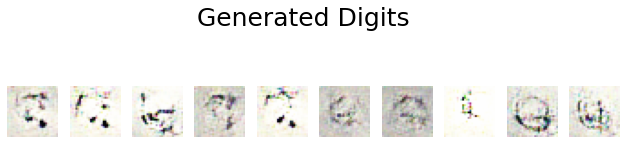

epoch:  951
discriminator loss:  0.39456671476364136
generator loss:  1.2773714065551758
--------------------------------------------------------------------------------
epoch:  952
discriminator loss:  0.3919593393802643
generator loss:  1.5355067253112793
--------------------------------------------------------------------------------
epoch:  953
discriminator loss:  0.37238433957099915
generator loss:  1.7165254354476929
--------------------------------------------------------------------------------
epoch:  954
discriminator loss:  0.40571707487106323
generator loss:  1.1523680686950684
--------------------------------------------------------------------------------
epoch:  955
discriminator loss:  0.4010127782821655
generator loss:  1.8792589902877808
--------------------------------------------------------------------------------


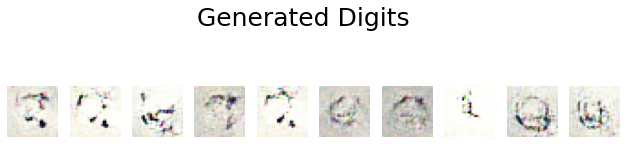

epoch:  956
discriminator loss:  0.40315672755241394
generator loss:  1.0447102785110474
--------------------------------------------------------------------------------
epoch:  957
discriminator loss:  0.40496039390563965
generator loss:  1.9329712390899658
--------------------------------------------------------------------------------
epoch:  958
discriminator loss:  0.39764297008514404
generator loss:  1.2381482124328613
--------------------------------------------------------------------------------
epoch:  959
discriminator loss:  0.4034746587276459
generator loss:  1.889817237854004
--------------------------------------------------------------------------------
epoch:  960
discriminator loss:  0.39825981855392456
generator loss:  1.1444369554519653
--------------------------------------------------------------------------------


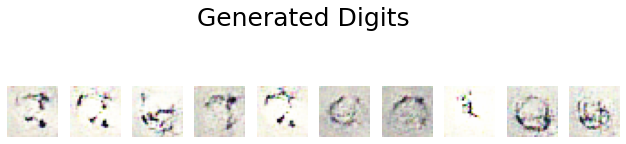

epoch:  961
discriminator loss:  0.4164406657218933
generator loss:  2.2045111656188965
--------------------------------------------------------------------------------
epoch:  962
discriminator loss:  0.4198620617389679
generator loss:  0.8228766918182373
--------------------------------------------------------------------------------
epoch:  963
discriminator loss:  0.46469825506210327
generator loss:  2.194873809814453
--------------------------------------------------------------------------------
epoch:  964
discriminator loss:  0.4083111882209778
generator loss:  1.2959119081497192
--------------------------------------------------------------------------------
epoch:  965
discriminator loss:  0.38519585132598877
generator loss:  1.6430855989456177
--------------------------------------------------------------------------------


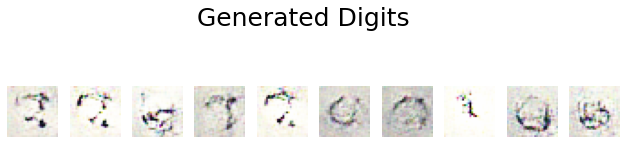

epoch:  966
discriminator loss:  0.37819716334342957
generator loss:  1.8944090604782104
--------------------------------------------------------------------------------
epoch:  967
discriminator loss:  0.37763211131095886
generator loss:  1.26591157913208
--------------------------------------------------------------------------------
epoch:  968
discriminator loss:  0.3840385675430298
generator loss:  1.9803528785705566
--------------------------------------------------------------------------------
epoch:  969
discriminator loss:  0.38327595591545105
generator loss:  1.2985438108444214
--------------------------------------------------------------------------------
epoch:  970
discriminator loss:  0.38062652945518494
generator loss:  1.9997972249984741
--------------------------------------------------------------------------------


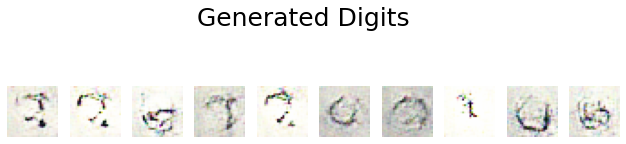

epoch:  971
discriminator loss:  0.39952409267425537
generator loss:  0.8567512631416321
--------------------------------------------------------------------------------
epoch:  972
discriminator loss:  0.4704100787639618
generator loss:  2.6623783111572266
--------------------------------------------------------------------------------
epoch:  973
discriminator loss:  0.4777064025402069
generator loss:  0.4630817770957947
--------------------------------------------------------------------------------
epoch:  974
discriminator loss:  0.653835117816925
generator loss:  1.6588406562805176
--------------------------------------------------------------------------------
epoch:  975
discriminator loss:  0.3911808729171753
generator loss:  2.3225257396698
--------------------------------------------------------------------------------


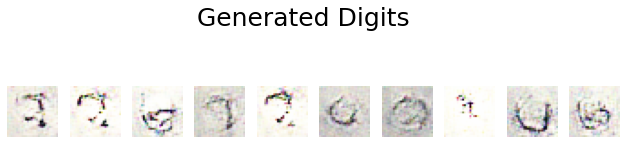

epoch:  976
discriminator loss:  0.4528125524520874
generator loss:  0.9100431203842163
--------------------------------------------------------------------------------
epoch:  977
discriminator loss:  0.45091599225997925
generator loss:  1.4784632921218872
--------------------------------------------------------------------------------
epoch:  978
discriminator loss:  0.39438340067863464
generator loss:  2.0420567989349365
--------------------------------------------------------------------------------
epoch:  979
discriminator loss:  0.4185516834259033
generator loss:  1.2224738597869873
--------------------------------------------------------------------------------
epoch:  980
discriminator loss:  0.3979361355304718
generator loss:  1.4754643440246582
--------------------------------------------------------------------------------


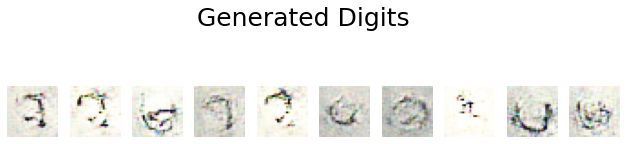

epoch:  981
discriminator loss:  0.3753836750984192
generator loss:  1.875321388244629
--------------------------------------------------------------------------------
epoch:  982
discriminator loss:  0.3862570822238922
generator loss:  1.355278491973877
--------------------------------------------------------------------------------
epoch:  983
discriminator loss:  0.39852866530418396
generator loss:  1.7957310676574707
--------------------------------------------------------------------------------
epoch:  984
discriminator loss:  0.3779963254928589
generator loss:  1.4576351642608643
--------------------------------------------------------------------------------
epoch:  985
discriminator loss:  0.38655054569244385
generator loss:  1.8595776557922363
--------------------------------------------------------------------------------


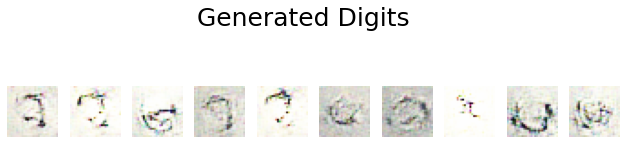

epoch:  986
discriminator loss:  0.39767560362815857
generator loss:  1.2533153295516968
--------------------------------------------------------------------------------
epoch:  987
discriminator loss:  0.409333735704422
generator loss:  2.227968215942383
--------------------------------------------------------------------------------
epoch:  988
discriminator loss:  0.4498320519924164
generator loss:  0.4733920991420746
--------------------------------------------------------------------------------
epoch:  989
discriminator loss:  0.6736682057380676
generator loss:  2.1975457668304443
--------------------------------------------------------------------------------
epoch:  990
discriminator loss:  0.44848933815956116
generator loss:  1.3845360279083252
--------------------------------------------------------------------------------


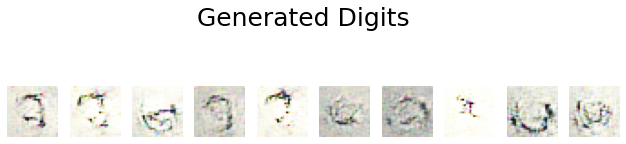

epoch:  991
discriminator loss:  0.4002460241317749
generator loss:  1.584608793258667
--------------------------------------------------------------------------------
epoch:  992
discriminator loss:  0.3844926059246063
generator loss:  1.817541241645813
--------------------------------------------------------------------------------
epoch:  993
discriminator loss:  0.39088261127471924
generator loss:  1.3885709047317505
--------------------------------------------------------------------------------
epoch:  994
discriminator loss:  0.3888587951660156
generator loss:  1.8055922985076904
--------------------------------------------------------------------------------
epoch:  995
discriminator loss:  0.3776857256889343
generator loss:  1.6054049730300903
--------------------------------------------------------------------------------


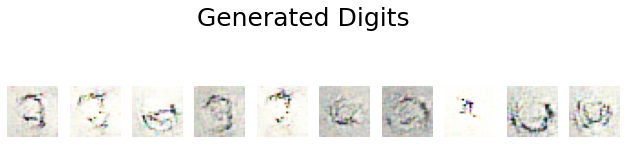

epoch:  996
discriminator loss:  0.37740451097488403
generator loss:  1.7215079069137573
--------------------------------------------------------------------------------
epoch:  997
discriminator loss:  0.37898924946784973
generator loss:  1.7165484428405762
--------------------------------------------------------------------------------
epoch:  998
discriminator loss:  0.38126125931739807
generator loss:  1.4663113355636597
--------------------------------------------------------------------------------
epoch:  999
discriminator loss:  0.3771098852157593
generator loss:  1.8666306734085083
--------------------------------------------------------------------------------


In [31]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, 28, 28, 3))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Digits", epoch)